In [1]:
import pandas as pd
import urllib

import numpy as np

import json

from tqdm.autonotebook import  tqdm

#%matplotlib inline

tqdm.pandas(tqdm)


# import jellyfish
import dask.dataframe as dd

from dask.multiprocessing import get


from importlib import reload

import AddressCleanserUtils
reload(AddressCleanserUtils)
from AddressCleanserUtils import *

# import multiprocessing
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

logging.getLogger("requests").setLevel(logging.WARNING)
logging.getLogger("urllib3").setLevel(logging.WARNING)


/home/vandy/.local/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


[2020-05-04 07:50:02,254]  Use default osm host : 10.0.2.15:7070
[2020-05-04 07:50:02,256]  Use default photon host: localhost:2322
[2020-05-04 07:50:02,258]  Use default libpostal host: localhost:2322


In [2]:
starting_time = datetime.now()

In [3]:
config_file = "config_batch"
address_file = "./address.csv.gz"
sample_size = None

import sys, getopt
opts, args = getopt.getopt(sys.argv[1:],"f:c:a:s:vq",[])

for opt, arg in opts:
    if opt == "-c":
        config_file = arg
        
    if opt == "-a":
        address_file = arg
        
    if opt == "-f":
        print("Run in jupyter ...", arg)
        AddressCleanserUtils.within_jupyter=True
        
    if opt == "-s":
        sample_size = int(arg)
        
    if opt == "-v": # Verbose
        logger.setLevel(logging.DEBUG)
        
    if opt == "-q": # quiet
        logger.setLevel(logging.WARNING)
        

Run in jupyter ... /home/vandy/.local/share/jupyter/runtime/kernel-09e6216b-6141-4cdf-a92c-7034568d0a56.json


In [4]:
if AddressCleanserUtils.within_jupyter :
    log("Running in Jupyter, using hardcoded parameters")
#     config_file = "config_best"
#     address_file = "./best.csv.gz"
    config_file = "config_batch"
    address_file = "./address.csv.gz"

    sample_size = 10000
    AddressCleanserUtils.photon_host = "172.26.0.1:2322"
    AddressCleanserUtils.libpostal_host = "172.26.0.1:8080"

# with_dask=False
# %matplotlib inline

[2020-05-04 07:50:02,323]  Running in Jupyter, using hardcoded parameters


In [5]:
import importlib
log(f"Loading config file {config_file}")
config_module = importlib.import_module(config_file)


[2020-05-04 07:50:02,340]  Loading config file config_batch


In [6]:
# Check that some required variables are present in the configuration file

field_names = ["street_field","housenbr_field","city_field","postcode_field", "country_field", "addr_key_field"]
#other_var_names = ["photon_host","osm_host","libpostal_host", "regex_replacements"]
other_var_names = ["regex_replacements"]
for var_name in field_names  + other_var_names:
    assert var_name in dir(config_module), var_name + " not defined in config module " + config_file


In [7]:
AddressCleanserUtils.street_field    = config_module.street_field
AddressCleanserUtils.housenbr_field  = config_module.housenbr_field
AddressCleanserUtils.city_field      = config_module.city_field
AddressCleanserUtils.postcode_field  = config_module.postcode_field
AddressCleanserUtils.country_field  = config_module.country_field

AddressCleanserUtils.addr_key_field  = config_module.addr_key_field

AddressCleanserUtils.regex_replacements = config_module.regex_replacements

AddressCleanserUtils.use_osm_parent      = use_osm_parent
AddressCleanserUtils.with_rest_libpostal = with_rest_libpostal

In [8]:
AddressCleanserUtils.pbar.register()

In [9]:
# Check that Nominatim server is running properly
try: 
    osm = get_osm("Bruxelles")
    assert osm[0]["namedetails"]["name:fr"] == "Bruxelles"
    
    vlog("OSM working properly")
    
    
except Exception as e: 
    print("OSM not up & running")
    print("OSM host: ", AddressCleanserUtils.osm_host)
    raise e


In [10]:
# In old version of Nominatim, page "details.php" could NOT return a JSON result, allowing to get place details from a place id
# In newer version, this has been added, allowing to get details about the parent of a place
# Is case "use_osm_parent" is true, check that "details.php" works correctly
if AddressCleanserUtils.use_osm_parent:
    try : 
        osm_det = get_osm_details(osm[0]["place_id"])
        assert osm_det["place_id"] == osm[0]["place_id"]

        vlog("OSM details working properly")

    except Exception as e: 
        print("OSM details not working")
        print("OSM host: ", AddressCleanserUtils.osm_host)
        raise e


In [11]:
# Check that Photon server is running properly
try: 
    ph = get_photon("Bruxelles")
    assert ph["features"][0]["properties"]["name"] == "Brussels" 
    vlog("Photon working properly")
    
    
except Exception as e: 
    print("Photon not up & running ; Start it with 'nohup java -jar photon-*.jar &'")
    print("Photon host: ", AddressCleanserUtils.photon_host)
    raise e


In [12]:
# Check that Libpostal is running properly
try: 
    lpost = parse_address("Bruxelles")
    assert lpost[0][0] == "bruxelles"
    vlog("Libpostal working properly")
except Exception as e: 
    print("Libpostal not up & running ")
    print("Libpostal: ", AddressCleanserUtils.libpostal_host)
    raise e


# Data preparation

In [13]:
# Get the addresses dataframe. Config module has to contain a "get_addresses(filename)" function, returning a dataframe, with 
# column names defined by variables (defined in config module) : street_field, housenbr_field, city_field, postcode_field , addr_key_field

log("Getting addresses")
addresses = config_module.get_addresses(address_file)
log(f"Got {addresses.shape[0]} addresses")
log(addresses)


[2020-05-04 07:50:03,081]  Getting addresses


/home/vandy/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


[2020-05-04 07:50:20,022]  Got 3101258 addresses


,EntityNumber,CountryFR,Zipcode,MunicipalityFR,StreetFR,HouseNumber
0,0200.065.765,Belgique,9070,Destelbergen,Panhuisstraat,1
1,0200.068.636,Belgique,9000,Gent,Stropstraat,1
2,0200.171.970,Belgique,9000,Gent,Brabantdam,101
3,0200.245.711,Belgique,9500,Geraardsbergen,Hoge Buizemont,247
4,0200.305.493,Belgique,9320,Aalst,Industrielaan,25
...,...,...,...,...,...,...
3112200,2.287.383.823,Belgique,2000.0,Antwerpen,Volkstraat,62-64
3112201,2.287.383.922,Belgique,2235.0,Hulshout,Ramselsesteenweg,52
3112202,2.287.384.021,Belgique,2910.0,Essen,Horendonk,316
3112203,2.287.384.120,Belgique,1060.0,Saint-Gilles,Rue de Danemark,30


In [14]:
if sample_size and sample_size < addresses.shape[0]:
    log(f"Keep a sample of size {sample_size}")
    addresses = addresses.sample(sample_size)


[2020-05-04 07:50:20,083]  Keep a sample of size 10000


In [15]:
# Check that all required fields are present in addresses dataframe

for field in field_names:
    assert config_module.__getattribute__(field) in addresses, f"Field {field} missing in data !"

In [16]:
# Check that the address identifier defined in config_module.addr_key_field is unique
assert addresses[addresses[config_module.addr_key_field].duplicated()].shape[0] == 0, "Key should be unique"

In [17]:
vlog("Stripping and upper casing...")
addresses = addresses.apply(lambda col: col.fillna("").astype(str).str.strip().str.upper() if col.dtype.kind=='O' else col.astype(str) )


# Main loop 

In [18]:
transformers_sequence = [ ["orig"],
                          ["regex[init]"],
                          ["nonum"],
                          ["libpostal", "regex[lpost]"], 
                          ["libpostal", "regex[lpost]", "nonum"], 
                          ["libpostal", "regex[lpost]", "photon"], 
                          ["libpostal", "regex[lpost]", "photon", "nonum"], 
                          ["photon"],
                          ["photon", "nonum"],
                          ["nostreet"]
                        ]

In [19]:
def main_loop(chunk):
    """
    Method "main_loop" processes the full cleansing sequence on a chunk of addresses : 
    - Apply a sequence of transformers (possibly empty)
    - Sent the (transformed) addresses to Nominatim
    - Parse and Check the results
    - For the addresses with no (accepted) result, try the next sequence of transformers
    """
    log(f"Chunk size: {chunk.shape[0]}")
    
    vlog(chunk)
    osm_addresses        = pd.DataFrame()
    rejected_addresses   = pd.DataFrame()
    stats = []
    
    init_chunk_size = chunk.shape[0]
    for transformers in transformers_sequence:

        vlog("--------------------------")
        vlog(f"| Transformers : { ';'.join(transformers) }")
        vlog("--------------------------")

#         display(chunk)
        osm_results, rejected, step_stats = transform_and_process(chunk, transformers, config_module.addr_key_field, 
                                                                  config_module.street_field, config_module.housenbr_field, 
                                                                  config_module.city_field, config_module.postcode_field,
                                                                  config_module.country_field)

        osm_addresses =      osm_addresses.append(osm_results, sort=False).drop_duplicates()
        rejected_addresses = rejected_addresses.append(rejected, sort=False).drop_duplicates()

        vlog("Results: ")
        vlog(osm_results.head())
        vlog(osm_results.shape)

        vlog(f"Match rate so far: {osm_addresses.shape[0] / init_chunk_size if init_chunk_size > 0 else '(empty chunk size)'}")
             
        stats.append(step_stats)
        vlog(step_stats)

        chunk  = chunk[~chunk[config_module.addr_key_field].isin(osm_results[config_module.addr_key_field])].copy()

        ts = AddressCleanserUtils.timestats
        tot = np.sum([ts[key] for key in ts])
        if tot.total_seconds()>0:
            for key in ts: 
                vlog(f"{key:12}: {ts[key]} ({100*ts[key]/tot:.3} %)")
             
        vlog("")
        vlog("")
        vlog("####################")
        vlog("")
        vlog("")
        
    log("Chunk results: ")
    log(osm_addresses)
    log(f"Chunk match rate: {(osm_addresses.shape[0] / init_chunk_size) if init_chunk_size > 0 else '(empty chunk size)'}")
    log(pd.DataFrame(stats))
    
    return osm_addresses, rejected_addresses, stats     

In [20]:
# Compute the number of chunks
min_nb_chunks= 4

if addresses.shape[0] > max_chunk_size * min_nb_chunks:
    chunk_size = max_chunk_size
    
elif addresses.shape[0] < min_chunk_size * min_nb_chunks:
    chunk_size = min_chunk_size
else: 
    chunk_size = int(np.sqrt(max_chunk_size *min_chunk_size))
log(f"Chunk_size: {chunk_size}")


[2020-05-04 07:50:21,012]  Chunk_size: 1000


Do the main processing, with dask or simply in sequential chunks. 

Processing a chunk may require at some point a huge amount of memory. A single chunk with a few millions addresses may result in memory error ; this is why we split the main addresses dataframe is smaller chunks.


In [21]:
stats = []


if with_dask : 
    
    from dask.diagnostics import Profiler, ResourceProfiler
    
    #AddressCleanserUtils.with_dask = False
    
    # Sorting : allow to increase the probability to have duplicates within a chunk
    dd_to_process = dd.from_pandas(addresses.sort_values([config_module.postcode_field, config_module.street_field]).reset_index(drop=True), 
                                   chunksize=chunk_size)

    dask_task = dd_to_process.map_partitions(main_loop)

    with Profiler() as prof, ResourceProfiler() as rprof : 
        res =  dask_task.compute(scheduler='processes')

    log("All chunks done, gather all results...")
    
    osm_addresses      = pd.concat([chunk_osm_addresses      for (chunk_osm_addresses, _, _)      in res], sort=False)
    rejected_addresses = pd.concat([chunk_rejected_addresses for (_, chunk_rejected_addresses, _) in res], sort=False)

    for (_, _, chunk_stats) in res: 
        stats.extend(chunk_stats)

    log(f"Global match rate: { osm_addresses.shape[0]/addresses.shape[0] } ")

else: 
    #AddressCleanserUtils.with_dask = True

    osm_addresses        = pd.DataFrame()
    rejected_addresses   = pd.DataFrame()

    chunks_boundaries =  range(chunk_size, addresses.shape[0] , chunk_size)

    for chunk in tqdm(np.array_split(addresses.sort_values([config_module.postcode_field, config_module.street_field]), chunks_boundaries)):


        chunk_osm_addresses, chunk_rejected_addresses, chunk_stats = main_loop(chunk)


        osm_addresses =      osm_addresses.append(chunk_osm_addresses, sort=False).drop_duplicates()
        rejected_addresses = rejected_addresses.append(chunk_rejected_addresses, sort=False).drop_duplicates()

        log(f"Global match rate so far: {osm_addresses.shape[0]/addresses.shape[0]}")
        stats.extend(chunk_stats)


[2020-05-04 07:50:21,124]  Chunk size: 2
[2020-05-04 07:50:21,299]  Chunk results: 


,EntityNumber


[2020-05-04 07:50:21,313]  Chunk match rate: 0.0


,method,todo,sent,match,match_26,reject_rec,reject_addr,reject_mism
0,orig,0,0,0,0,0,0,0
1,regex[init],0,0,0,0,0,0,0
2,nonum,0,0,0,0,0,0,0
3,libpostal+regex[lpost],0,0,0,0,0,0,0
4,libpostal+regex[lpost]+nonum,0,0,0,0,0,0,0
5,libpostal+regex[lpost]+photon,0,0,0,0,0,0,0
6,libpostal+regex[lpost]+photon+nonum,0,0,0,0,0,0,0
7,photon,0,0,0,0,0,0,0
8,photon+nonum,0,0,0,0,0,0,0
9,nostreet,0,0,0,0,0,0,0


[                                        ] | 0% Completed |  0.0s[2020-05-04 07:50:21,507]  Chunk size: 1000
[2020-05-04 07:50:21,586]  Chunk size: 1000
[                                        ] | 0% Completed |  1min 38.6s[2020-05-04 07:52:00,062]  Chunk results: 


,osm_addr_in,EntityNumber,place_id,lat,lon,display_name,namedetails,place_rank,category,type,SIM_street_which,SIM_street,addr_out_street,addr_out_city,addr_out_number,addr_out_country,addr_out_postcode,addr_out_other,retry_on_26,method
461,"RUE SEUTIN, 25, 1030 SCHAERBEEK, BELGIQUE",0211.256.892,1209629.0,50.8590948,4.37241046262002,"25, Rue Seutin - Seutinstraat, Schaerbeek - Sc...",,30.0,building,yes,addr_out_street,1.0,Rue Seutin - Seutinstraat,Schaerbeek - Schaarbeek,25,België / Belgique / Belgien,1030,,NaN,orig
1030,"RUE DES ETANGS NOIRS, 48, 1080 MOLENBEEK-SAINT...",0235.059.110,1334096.0,50.8561625,4.33071912706498,"48, Rue des Étangs Noirs - Zwarte Vijversstraa...",,30.0,building,yes,addr_out_street,1.0,Rue des Étangs Noirs - Zwarte Vijversstraat,Molenbeek-Saint-Jean - Sint-Jans-Molenbeek,48,België / Belgique / Belgien,1080,,NaN,orig
98,"PLACE DES ARMATEURS, 6, 1000 BRUXELLES, BELGIQUE",0249.268.719,1725246.0,50.864298,4.3536687,"Place des Armateurs - Redersplein, BXL, Ville ...",Place des Armateurs - Redersplein - Place des ...,26.0,highway,tertiary,addr_out_street,1.0,Place des Armateurs - Redersplein,BXL,None,België / Belgique / Belgien,1000,,NaN,orig
753,"RUE SAINT-GEORGES, 24, 1050 IXELLES, BELGIQUE",0400.379.277,200797.0,50.8184308,4.3691638,"24, Rue Saint-Georges - Sint-Jorisstraat, Ixel...",,30.0,place,house,addr_out_street,1.0,Rue Saint-Georges - Sint-Jorisstraat,Ixelles - Elsene,24,België / Belgique / Belgien,1050,,NaN,orig
689,"RUE CLÉMENTINE, 1, 1050 IXELLES, BELGIQUE",0400.567.636,215799.0,50.8311774,4.374676,"1, Rue Clémentine - Clementinestraat, Ixelles ...",,30.0,place,house,addr_out_street,1.0,Rue Clémentine - Clementinestraat,Ixelles - Elsene,1,België / Belgique / Belgien,1050,,NaN,orig
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39,"1080 MOLENBEEK-SAINT-JEAN, BELGIQUE",2.011.004.097,2794878.0,50.8545959,4.338636,"Molenbeek-Saint-Jean - Sint-Jans-Molenbeek, Br...",,16.0,boundary,administrative,addr_out_street,1.0,None,Brussel-Hoofdstad - Bruxelles-Capitale,NaN,België / Belgique / Belgien,1080,,NaN,nostreet
35,"1080 MOLENBEEK-SAINT-JEAN, BELGIQUE",2.020.618.975,2794878.0,50.8545959,4.338636,"Molenbeek-Saint-Jean - Sint-Jans-Molenbeek, Br...",,16.0,boundary,administrative,addr_out_street,1.0,None,Brussel-Hoofdstad - Bruxelles-Capitale,NaN,België / Belgique / Belgien,1080,,NaN,nostreet
0,"1000 BRUXELLES, BELGIQUE",2.027.162.616,153482.0,50.8465573,4.351697,"BXL, Brussel-Hoofdstad - Bruxelles-Capitale, R...",,15.0,place,city,addr_out_street,1.0,None,Brussel-Hoofdstad - Bruxelles-Capitale,NaN,België / Belgique / Belgien,1000,,NaN,nostreet
43,"1081 KOEKELBERG, BELGIQUE",2.027.723.038,2796845.0,50.8606042,4.3315503,"Koekelberg, Brussel-Hoofdstad - Bruxelles-Capi...",,16.0,boundary,administrative,addr_out_street,1.0,None,Brussel-Hoofdstad - Bruxelles-Capitale,NaN,België / Belgique / Belgien,1081,,NaN,nostreet


[2020-05-04 07:52:00,174]  Chunk match rate: 0.995


,method,todo,sent,match,match_26,reject_rec,reject_addr,reject_mism
0,orig,1000,1000,873,40,264,122,0
1,regex[init],127,76,72,1,20,9,0
2,nonum,55,47,34,0,18,4,0
3,libpostal+regex[lpost],21,7,0,0,0,0,0
4,libpostal+regex[lpost]+nonum,21,13,1,0,0,0,0
5,libpostal+regex[lpost]+photon,20,6,6,0,3,2,0
6,libpostal+regex[lpost]+photon+nonum,0,0,0,0,0,0,0
7,photon,14,3,3,0,0,0,0
8,photon+nonum,0,0,0,0,0,0,0
9,nostreet,11,11,6,0,45,6,3


[2020-05-04 07:52:00,703]  Chunk size: 1000
[####                                    ] | 10% Completed |  2min 21.9s[2020-05-04 07:52:43,472]  Chunk results: 


,osm_addr_in,EntityNumber,place_id,lat,lon,display_name,namedetails,place_rank,category,type,SIM_street_which,SIM_street,addr_out_street,addr_out_city,addr_out_number,addr_out_country,addr_out_postcode,addr_out_other,retry_on_26,method
69,"AVENUE DES MUGUETS, 11, 1150 WOLUWE-SAINT-PIER...",0401.963.743,1380604.0,50.8298177,4.42021526676221,"11, Avenue des Muguets - Meiklokjeslaan, Woluw...",,30.0,building,yes,addr_out_street,1.0,Avenue des Muguets - Meiklokjeslaan,Woluwe-Saint-Pierre - Sint-Pieters-Woluwe,11,België / Belgique / Belgien,1150,,NaN,orig
156,"AVENUE EMILE VAN BECELAERE, 9, 1170 WATERMAEL-...",0402.003.434,938997.0,50.797095,4.40742232915867,"9, Avenue Emile Van Becelaere - Emile Van Bece...",,30.0,building,yes,addr_out_street,1.0,Avenue Emile Van Becelaere - Emile Van Becelae...,Watermael-Boitsfort - Watermaal-Bosvoorde,9,België / Belgique / Belgien,1170,,NaN,orig
227,"CHAUSSÉE D'ALSEMBERG, 830, 1180 UCCLE, BELGIQUE",0402.967.296,232201.0,50.7968087,4.3360305,"830, Chaussée d'Alsemberg - Alsembergsesteenwe...",,30.0,place,house,addr_out_street,1.0,Chaussée d'Alsemberg - Alsembergsesteenweg,Uccle - Ukkel,830,België / Belgique / Belgien,1180,,NaN,orig
466,"RUE SAINT-ALPHONSE, 30, 1210 SAINT-JOSSE-TEN-N...",0403.318.575,1277577.0,50.85145145,4.37170418878543,"30, Rue Saint-Alphonse - Sint-Alfonsstraat, Sa...",,30.0,building,yes,addr_out_street,1.0,Rue Saint-Alphonse - Sint-Alfonsstraat,Saint-Josse-ten-Noode - Sint-Joost-ten-Node,30,België / Belgique / Belgien,1210,,NaN,orig
373,"RUE PIERRE DECOSTER, 112, 1190 FOREST, BELGIQUE",0403.545.041,1299582.0,50.822895,4.32959561258803,"112, Rue Pierre Decoster - Pierre Decosterstra...",,30.0,building,yes,addr_out_street,1.0,Rue Pierre Decoster - Pierre Decosterstraat,Forest - Vorst,112,België / Belgique / Belgien,1190,,NaN,orig
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,"1640 SINT-GENESIUS-RODE, BELGIQUE",0478.455.765,2802244.0,50.7439988,4.37539567573769,"Sint-Genesius-Rode, Halle-Vilvoorde, Vlaams-Br...",,21.0,place,postcode,addr_out_street,1.0,None,Sint-Genesius-Rode,NaN,België / Belgique / Belgien,1640,,NaN,nostreet
27,"1640 SINT-GENESIUS-RODE, BELGIQUE",0654.878.276,2802244.0,50.7439988,4.37539567573769,"Sint-Genesius-Rode, Halle-Vilvoorde, Vlaams-Br...",,21.0,place,postcode,addr_out_street,1.0,None,Sint-Genesius-Rode,NaN,België / Belgique / Belgien,1640,,NaN,nostreet
0,"1160 AUDERGHEM, BELGIQUE",2.017.565.059,2810066.0,50.8172355,4.4268982,"Auderghem - Oudergem, Brussel-Hoofdstad - Brux...",,16.0,boundary,administrative,addr_out_street,1.0,None,Brussel-Hoofdstad - Bruxelles-Capitale,NaN,België / Belgique / Belgien,1160,,NaN,nostreet
15,"1320.0 BEAUVECHAIN, BELGIQUE",2.098.347.649,2734327.0,50.77889175,4.77022521096751,"Ferme de l'Espinette, Beauvechain, Nivelles, B...",,21.0,place,postcode,addr_out_street,1.0,None,Beauvechain,NaN,België / Belgique / Belgien,1320,Ferme de l'Espinette,NaN,nostreet


[2020-05-04 07:52:43,562]  Chunk match rate: 0.989


,method,todo,sent,match,match_26,reject_rec,reject_addr,reject_mism
0,orig,1000,1000,782,18,261,170,5
1,regex[init],218,139,121,2,58,27,1
2,nonum,97,92,15,0,15,10,3
3,libpostal+regex[lpost],82,20,0,0,0,0,0
4,libpostal+regex[lpost]+nonum,82,70,1,0,6,3,3
5,libpostal+regex[lpost]+photon,81,58,58,2,8,6,0
6,libpostal+regex[lpost]+photon+nonum,0,0,0,0,0,0,0
7,photon,23,5,5,0,0,0,0
8,photon+nonum,0,0,0,0,0,0,0
9,nostreet,18,18,7,0,22,10,4


[2020-05-04 07:52:44,129]  Chunk size: 1000
[########                                ] | 20% Completed |  3min 53.6s[2020-05-04 07:54:15,432]  Chunk results: 


,osm_addr_in,EntityNumber,place_id,lat,lon,display_name,namedetails,place_rank,category,type,SIM_street_which,SIM_street,addr_out_street,addr_out_city,addr_out_number,addr_out_country,addr_out_postcode,addr_out_other,retry_on_26,method
297,"NIJVERHEIDSSTRAAT, 12, 1800 VILVOORDE, BELGIQUE",0400.701.258,1495526.0,50.9289821,4.4349040816609,"12, Nijverheidsstraat, Vilvoorde, Halle-Vilvoo...",,30.0,building,yes,addr_out_street,1.0,Nijverheidsstraat,Vilvoorde,12,België / Belgique / Belgien,1800,,NaN,orig
45,"BRUSSELSTRAAT, 214, 1702 DILBEEK, BELGIQUE",0400.745.701,542068.0,50.8686963,4.2719184,"Brusselstraat, Groot-Bijgaarden, Dilbeek, Hall...",Brusselstraat,26.0,highway,tertiary,addr_out_street,1.0,Brusselstraat,Dilbeek,None,België / Belgique / Belgien,1702,,NaN,orig
54,"PETER BENOITSTRAAT, 7, 1702 DILBEEK, BELGIQUE",0400.753.619,2672841.0,50.8668122,4.2711929,"Peter Benoitstraat, Groot-Bijgaarden, Dilbeek,...",Peter Benoitstraat,26.0,highway,residential,addr_out_street,1.0,Peter Benoitstraat,Dilbeek,None,België / Belgique / Belgien,1702,,NaN,orig
356,"JOZEF VAN ELEWIJCKSTRAAT, 59, 1853 GRIMBERGEN,...",0401.868.921,2676819.0,50.9039043,4.352546,"59, Jozef Van Elewijckstraat, Strombeek-Bever,...",,30.0,building,yes,addr_out_street,1.0,Jozef Van Elewijckstraat,Strombeek-Bever,59,België / Belgique / Belgien,1853,,NaN,orig
1020,"TAXANDRIASTRAAT, 15, 2170 ANTWERPEN, BELGIQUE",0403.746.959,1901488.0,51.2399418,4.43616741469939,"15, Taxandriastraat, Merksem, Antwerpen, Vlaan...",,30.0,building,house,addr_out_street,1.0,Taxandriastraat,Merksem,15,België / Belgique / Belgien,2170,,NaN,orig
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,"1731 ASSE, BELGIQUE",0405.940.347,2797233.0,50.9094333,4.2015646,"Asse, Halle-Vilvoorde, Vlaams-Brabant, Vlaande...",,16.0,boundary,administrative,addr_out_street,1.0,None,Halle-Vilvoorde,NaN,België / Belgique / Belgien,None,NaN,NaN,nostreet
2,"1703 DILBEEK, BELGIQUE",0837.038.140,2810099.0,50.8480711,4.2662591,"Dilbeek, Halle-Vilvoorde, Vlaams-Brabant, Vlaa...",,16.0,boundary,administrative,addr_out_street,1.0,None,Halle-Vilvoorde,NaN,België / Belgique / Belgien,None,NaN,NaN,nostreet
19,"1750 LENNIK, BELGIQUE",2.037.151.834,2810169.0,50.8085632,4.1648626,"Lennik, Halle-Vilvoorde, Vlaams-Brabant, Vlaan...",,16.0,boundary,administrative,addr_out_street,1.0,None,Halle-Vilvoorde,NaN,België / Belgique / Belgien,1750,NaN,NaN,nostreet
33,"2000 ANTWERPEN, BELGIQUE",2.141.219.372,2340330.0,51.2140059,4.39221116927601,"Antwerpen, Vlaanderen, 2000, België / Belgique...",,21.0,place,postcode,addr_out_street,1.0,None,Antwerpen,NaN,België / Belgique / Belgien,2000,NaN,NaN,nostreet


[2020-05-04 07:54:15,523]  Chunk match rate: 0.986


,method,todo,sent,match,match_26,reject_rec,reject_addr,reject_mism
0,orig,1000,1000,811,19,356,182,1
1,regex[init],189,123,116,0,37,23,0
2,nonum,73,68,11,0,37,12,3
3,libpostal+regex[lpost],62,31,1,0,2,1,0
4,libpostal+regex[lpost]+nonum,61,50,0,0,7,3,3
5,libpostal+regex[lpost]+photon,61,36,36,0,5,3,0
6,libpostal+regex[lpost]+photon+nonum,0,0,0,0,0,0,0
7,photon,25,6,6,0,4,2,0
8,photon+nonum,0,0,0,0,0,0,0
9,nostreet,19,19,5,0,33,11,8


[2020-05-04 07:54:16,048]  Chunk size: 1000
[############                            ] | 30% Completed |  4min 12.8s[2020-05-04 07:54:34,789]  Chunk results: 


,osm_addr_in,EntityNumber,place_id,lat,lon,display_name,namedetails,place_rank,category,type,SIM_street_which,SIM_street,addr_out_street,addr_out_city,addr_out_number,addr_out_country,addr_out_postcode,addr_out_other,retry_on_26,method
670,"STEENWEG OP WAARLOOS, 33, 2840 RUMST, BELGIQUE",0400.788.756,761049.0,51.1013851,4.42199212511331,"33, Steenweg op Waarloos, Reet, Rumst, Antwerp...",,30.0,building,yes,addr_out_street,1.0,Steenweg op Waarloos,Rumst,33,België / Belgique / Belgien,2840,,NaN,orig
605,"OVERHEIDE, 34, 2800 MECHELEN, BELGIQUE",0403.604.528,1735956.0,51.0402033,4.47370745635035,"34, Overheide, Marokken, Mechelen, Antwerpen, ...",,30.0,building,yes,addr_out_street,1.0,Overheide,Mechelen,34,België / Belgique / Belgien,2800,Marokken,NaN,orig
643,"EMIEL VANDERVELDESTRAAT, 2A, 2830 WILLEBROEK, ...",0403.678.960,2648990.0,51.0608254,4.3582862,"Emiel Vanderveldestraat, Willebroek, Mechelen,...",Emiel Vanderveldestraat,26.0,highway,residential,addr_out_street,1.0,Emiel Vanderveldestraat,Willebroek,None,België / Belgique / Belgien,2830,,NaN,orig
676,"MATENSTRAAT, 11, 2845 NIEL, BELGIQUE",0403.690.541,1143763.0,51.11236145,4.33833665889218,"11-13, Matenstraat, Niel, Antwerpen, Vlaandere...",,30.0,building,house,addr_out_street,1.0,Matenstraat,Niel,11-13,België / Belgique / Belgien,2845,,NaN,orig
740,"BRECHTSEBAAN, 114, 2900 SCHOTEN, BELGIQUE",0403.708.951,1898846.0,51.26748665,4.51453493653846,"114,114A,114B,114C, Brechtsebaan, Schoten, Ant...",,30.0,building,yes,addr_out_street,1.0,Brechtsebaan,Schoten,"114,114A,114B,114C",België / Belgique / Belgien,2900,,NaN,orig
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,"Mechelbaan, , 2580 Putte, Belgium",0857.441.297,572785.0,51.060704,4.6525506,"Mechelbaan, Beerzel, Putte, Mechelen, Antwerpe...",N15 - Mechelbaan,26.0,highway,primary,addr_out_street,1.0,Mechelbaan,Putte,NaN,België / Belgique / Belgien,2580,NaN,NaN,photon
0,"Henri Spillemaekersstraat, 7, 2850 Boom, Belgium",2.165.270.028,1026495.0,51.0867844,4.36315527297753,"7;7B;8B, Henri Spillemaekersstraat, Boom, Antw...",,30.0,building,yes,addr_out_street,1.0,Henri Spillemaekersstraat,Boom,7;7B;8B,België / Belgique / Belgien,2850,NaN,True,photon
2,"2440 GEEL, BELGIQUE",0404.213.945,1473637.0,51.1607775,4.98759141980118,"Geel, Turnhout, Antwerpen, Vlaanderen, 2440, B...",,21.0,place,postcode,addr_out_street,1.0,None,Geel,NaN,België / Belgique / Belgien,2440,,NaN,nostreet
12,"2950 KAPELLEN, BELGIQUE",0462.303.582,2810756.0,51.32821335,4.4351642287262,"Kapellen, Antwerpen, Vlaanderen, 2950, België ...",,21.0,place,postcode,addr_out_street,1.0,None,Kapellen,NaN,België / Belgique / Belgien,2950,,NaN,nostreet


[2020-05-04 07:54:34,928]  Chunk match rate: 0.992


,method,todo,sent,match,match_26,reject_rec,reject_addr,reject_mism
0,orig,1000,1000,831,16,188,107,5
1,regex[init],169,143,139,3,33,19,0
2,nonum,30,28,8,0,9,6,1
3,libpostal+regex[lpost],22,6,0,0,0,0,0
4,libpostal+regex[lpost]+nonum,22,18,0,0,1,1,1
5,libpostal+regex[lpost]+photon,22,9,8,0,0,0,0
6,libpostal+regex[lpost]+photon+nonum,14,1,1,0,1,1,0
7,photon,13,2,2,1,5,1,0
8,photon+nonum,0,0,0,0,0,0,0
9,nostreet,11,11,3,0,11,5,2


[############                            ] | 30% Completed |  4min 13.8s[2020-05-04 07:54:35,513]  Chunk size: 1000
[################                        ] | 40% Completed |  6min 25.7s[2020-05-04 07:56:47,215]  Chunk results: 


,osm_addr_in,EntityNumber,place_id,lat,lon,display_name,namedetails,place_rank,category,type,SIM_street_which,SIM_street,addr_out_street,addr_out_city,addr_out_number,addr_out_country,addr_out_postcode,addr_out_other,retry_on_26,method
253,"PASTORIESTRAAT, 8, 3128 TREMELO, BELGIQUE",0400.936.929,1718135.0,50.9960856,4.752697,"8, Pastoriestraat, Baal, Tremelo, Leuven, Vlaa...",,30.0,building,house,addr_out_street,1.0,Pastoriestraat,Tremelo,8,België / Belgique / Belgien,3128,,NaN,orig
391,"WESTELSEBAAN, 170, 3271 SCHERPENHEUVEL-ZICHEM,...",0400.937.919,425072.0,51.0288029,4.9803427,"Ceusters & Co bvba, 170, Westelsebaan, Averbod...",,30.0,office,insurance,addr_out_street,1.0,Westelsebaan,Scherpenheuvel-Zichem,170,België / Belgique / Belgien,3271,Ceusters & Co bvba,NaN,orig
986,"TRANSPORTLAAN, 4, 3600 GENK, BELGIQUE",0401.296.720,568025.0,50.9980819,5.46600522139425,"H.Essers, 4, Transportlaan, Staatstuinwijk, Te...",,30.0,building,industrial,addr_out_street,1.0,Transportlaan,Genk,4,België / Belgique / Belgien,3600,Termien - H.Essers - Staatstuinwijk,NaN,orig
703,"BERKENSTRAAT, 93, 3530 HOUTHALEN-HELCHTEREN, B...",0401.309.289,1428494.0,51.0319379,5.4756973,"Berkenstraat, Houthalen, Houthalen-Helchteren,...",Berkenstraat,26.0,highway,residential,addr_out_street,1.0,Berkenstraat,Houthalen-Helchteren,None,België / Belgique / Belgien,3530,,NaN,orig
58,"EÉNMEILAAN, 37, 3010 LEUVEN, BELGIQUE",0403.563.451,1023952.0,50.8919255,4.7181458,"Eénmeilaan, Blauwput, Kessel-Lo, Leuven, Vlaam...",Eénmeilaan,26.0,highway,tertiary,addr_out_street,1.0,Eénmeilaan,Kessel-Lo,None,België / Belgique / Belgien,3010,Blauwput - Kessel-Lo,NaN,orig
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,"3800 SINT-TRUIDEN, BELGIQUE",0883.415.721,1753015.0,50.8150314,5.20522619338898,"Sint-Truiden, Hasselt, Limburg, Vlaanderen, 38...",,21.0,place,postcode,addr_out_street,1.0,NaN,Sint-Truiden,NaN,België / Belgique / Belgien,3800,NaN,NaN,nostreet
14,"3300 TIENEN, BELGIQUE",2.139.496.534,259200.0,50.8157941,4.9369477,"Tienen, Leuven, Vlaams-Brabant, Vlaanderen, 33...",,21.0,place,postcode,addr_out_street,1.0,NaN,Tienen,NaN,België / Belgique / Belgien,3300,NaN,NaN,nostreet
12,"3212.0 LUBBEEK, BELGIQUE",2.172.382.207,657240.0,50.8711735,4.78084375,"Pellenberg, Lubbeek, Leuven, Vlaams-Brabant, V...",,21.0,place,postcode,addr_out_street,1.0,NaN,Lubbeek,NaN,België / Belgique / Belgien,3212,NaN,NaN,nostreet
0,"3090 OVERIJSE, BELGIQUE",2.242.139.855,2802558.0,50.76768825,4.55711864155734,"Overijse, Halle-Vilvoorde, Vlaams-Brabant, Vla...",,21.0,place,postcode,addr_out_street,1.0,NaN,Overijse,NaN,België / Belgique / Belgien,3090,NaN,NaN,nostreet


[2020-05-04 07:56:47,311]  Chunk match rate: 0.984


,method,todo,sent,match,match_26,reject_rec,reject_addr,reject_mism
0,orig,1000,1000,821,8,523,280,3
1,regex[init],179,148,140,0,121,55,1
2,nonum,39,39,5,0,14,7,2
3,libpostal+regex[lpost],34,9,0,0,0,0,0
4,libpostal+regex[lpost]+nonum,34,28,0,0,4,2,2
5,libpostal+regex[lpost]+photon,34,9,8,0,5,3,1
6,libpostal+regex[lpost]+photon+nonum,26,1,1,0,3,1,1
7,photon,25,2,2,0,0,0,0
8,photon+nonum,0,0,0,0,0,0,0
9,nostreet,23,23,7,0,21,7,0


[2020-05-04 07:56:48,021]  Chunk size: 1000
[####################                    ] | 50% Completed |  7min 17.3s[2020-05-04 07:57:39,514]  Chunk results: 


,osm_addr_in,EntityNumber,place_id,lat,lon,display_name,namedetails,place_rank,category,type,SIM_street_which,SIM_street,addr_out_street,addr_out_city,addr_out_number,addr_out_country,addr_out_postcode,addr_out_other,retry_on_26,method
625,"RUE DE LA CROIX, 70, 4357 DONCEEL, BELGIQUE",0211.177.314,572601.0,50.6471272,5.3056342,"Rue de la Croix, Donceel, Waremme, Liège, Wall...",Rue de la Croix,26.0,highway,residential,addr_out_street,1.0,Rue de la Croix,Donceel,None,België / Belgique / Belgien,4357,,NaN,orig
829,"HAASSTRASSE, 52, 4700 EUPEN, BELGIQUE",0211.179.985,1478734.0,50.6227621,6.03944919032807,"Pfarrbüro ST. JOSEF, 52, Haasstraße, Unterstad...",,30.0,building,yes,addr_out_street,1.0,Haasstraße,Eupen,52,België / Belgique / Belgien,4700,Unterstadt - Pfarrbüro ST. JOSEF,NaN,orig
50,"BERGEYKSEWEG, 32, 3900 PELT, BELGIQUE",0211.289.853,730689.0,51.22665995,5.41538978877003,"32, Bergeykseweg, Overpelt, Pelt, Maaseik, Lim...",,30.0,building,house,addr_out_street,1.0,Bergeykseweg,Pelt,32,België / Belgique / Belgien,3900,,NaN,orig
1005,"PLACE DU PERRON, 2, 4910 THEUX, BELGIQUE",0212.227.288,601594.0,50.53496035,5.81332448480055,"Administration communale de Theux, 2, Place du...",,30.0,amenity,townhall,addr_out_street,1.0,Place du Perron,Theux,2,België / Belgique / Belgien,4910,Administration communale de Theux,NaN,orig
196,"BOULEVARD DE LA SAUVENIÈRE, 156, 4000 LIÈGE, B...",0402.425.284,1317450.0,50.6436855,5.5667392,"Boulevard de la Sauvenière, Pierreuse, Glain, ...",N617 - Boulevard de la Sauvenière,26.0,highway,secondary,addr_out_street,1.0,Boulevard de la Sauvenière,Liège,None,België / Belgique / Belgien,4000,Pierreuse - Glain,NaN,orig
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39,"4141 SPRIMONT, BELGIQUE",2.208.442.154,2297085.0,50.52309455,5.68438715796456,"Louveigné, Sprimont, Liège, Wallonie, 4141, Be...",,21.0,place,postcode,addr_out_street,1.0,None,Sprimont,NaN,België / Belgique / Belgien,4141,,NaN,nostreet
32,"4031 LIÈGE, BELGIQUE",2.226.540.968,2480541.0,50.566209,5.58434956962437,"Tilff, Esneux, Liège, Wallonie, 4031, België /...",,21.0,place,postcode,addr_out_street,1.0,None,Esneux,NaN,België / Belgique / Belgien,4031,,NaN,nostreet
4,"4000 LIÈGE, BELGIQUE",2.237.409.918,2810350.0,50.6451381,5.5734203,"Liège, Wallonie, 4000, België / Belgique / Bel...",,16.0,place,city,addr_out_street,1.0,None,Liège,NaN,België / Belgique / Belgien,4000,,NaN,nostreet
87,"4960.0 MALMEDY, BELGIQUE",2.249.340.423,900805.0,50.44170285,6.03934739976726,"Bagatelle, Malmedy, Verviers, Liège, Wallonie,...",,21.0,place,postcode,addr_out_street,1.0,None,Malmedy,NaN,België / Belgique / Belgien,4960,Bagatelle,NaN,nostreet


[2020-05-04 07:57:39,692]  Chunk match rate: 0.981
[####################                    ] | 50% Completed |  7min 18.4s

,method,todo,sent,match,match_26,reject_rec,reject_addr,reject_mism
0,orig,1000,1000,706,11,330,202,11
1,regex[init],294,185,165,4,74,49,1
2,nonum,129,128,15,0,16,12,7
3,libpostal+regex[lpost],114,34,4,0,1,1,1
4,libpostal+regex[lpost]+nonum,110,99,1,0,9,8,7
5,libpostal+regex[lpost]+photon,109,58,56,0,33,22,1
6,libpostal+regex[lpost]+photon+nonum,53,2,1,0,1,1,1
7,photon,52,5,5,0,4,2,0
8,photon+nonum,0,0,0,0,0,0,0
9,nostreet,47,47,28,0,61,24,0


[2020-05-04 07:57:40,507]  Chunk size: 1000
[########################                ] | 60% Completed |  9min 59.4s[2020-05-04 08:00:21,679]  Chunk results: 


,osm_addr_in,EntityNumber,place_id,lat,lon,display_name,namedetails,place_rank,category,type,SIM_street_which,SIM_street,addr_out_street,addr_out_city,addr_out_number,addr_out_country,addr_out_postcode,addr_out_other,retry_on_26,method
209,"RUE DE LA CROISETTE, 2, 5575 GEDINNE, BELGIQUE",0212.357.942,441259,49.9791772,4.9365055,"Coiffure Dany, 2, Rue de la Croisette, Gedinne...",,30,shop,hairdresser,addr_out_street,1.0,Rue de la Croisette,Gedinne,2,België / Belgique / Belgien,5575,Coiffure Dany,NaN,orig
27,"RUE DE L'ANGE, 21, 5000 NAMUR, BELGIQUE",0401.373.231,133253,50.4632161,4.8658618,"Delahaut, 21, Rue de l'Ange, Salzinnes, Namur,...",,30,amenity,cafe,addr_out_street,1.0,Rue de l'Ange,Namur,21,België / Belgique / Belgien,5000,Delahaut - Salzinnes,NaN,orig
28,"RUE DE L'ETOILE, 9, 5000 NAMUR, BELGIQUE",0401.422.919,536977,50.4656871,4.8699581,"Rue de l'Étoile, Salzinnes, Namur, Wallonie, 5...",Rue de l'Étoile,26,highway,living_street,addr_out_street,1.0,Rue de l'Étoile,Namur,None,België / Belgique / Belgien,5000,Salzinnes,NaN,orig
336,"ROUTE DE MONS 12-16, , 6020 CHARLEROI, BELGIQUE",0401.614.246,1456404,50.4124598,4.4270059,"Route de Mons, Dampremy, Charleroi, Hainaut, W...",Route de Mons,26,highway,primary,addr_out_street,1.0,Route de Mons,Dampremy,None,België / Belgique / Belgien,6020,,NaN,orig
52,"CHAUSSÉE DE WAVRE, 42, 5030 GEMBLOUX, BELGIQUE",0406.874.022,114270,50.575814,4.6887587,"Champ Bleu, 42, Chaussée de Wavre, Gembloux, N...",,30,amenity,restaurant,addr_out_street,1.0,Chaussée de Wavre,Gembloux,42,België / Belgique / Belgien,5030,Champ Bleu,NaN,orig
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,"5500.0 DINANT, BELGIQUE",2.180.850.604,2800471,50.2016705,4.89531963719008,"Falmagne, Dinant, Namur, Wallonie, 5500, Belgi...",,21,place,postcode,addr_out_street,1.0,None,Falmagne,NaN,België / Belgique / Belgien,5500,,NaN,nostreet
25,"5630 CERFONTAINE, BELGIQUE",2.220.410.469,2812941,50.2068537244853,4.44438084960347,"Cerfontaine, Wallonie, 5630, België / Belgique...",,21,place,postcode,addr_out_street,1.0,None,Cerfontaine,NaN,België / Belgique / Belgien,5630,,NaN,nostreet
55,"6596 MOMIGNIES, BELGIQUE",2.241.650.796,2813019,50.0080909614615,4.26722488970271,"Momignies, Wallonie, 6596, België / Belgique /...",,21,place,postcode,addr_out_street,1.0,None,Momignies,NaN,België / Belgique / Belgien,6596,,NaN,nostreet
84,"7000.0 MONS, BELGIQUE",2.249.489.584,2453831,50.45623985,3.95512054987159,"Mons, Hainaut, Wallonie, 7000, België / Belgiq...",,21,place,postcode,addr_out_street,1.0,None,Mons,NaN,België / Belgique / Belgien,7000,,NaN,nostreet


[2020-05-04 08:00:21,768]  Chunk match rate: 0.977


,method,todo,sent,match,match_26,reject_rec,reject_addr,reject_mism
0,orig,1000,1000,522,5,238,145,15
1,regex[init],478,326,279,3,109,82,9
2,nonum,199,195,28,0,36,22,11
3,libpostal+regex[lpost],171,96,8,0,7,4,2
4,libpostal+regex[lpost]+nonum,163,136,0,0,10,7,7
5,libpostal+regex[lpost]+photon,163,86,82,0,26,23,1
6,libpostal+regex[lpost]+photon+nonum,81,4,3,0,1,1,1
7,photon,78,13,12,0,0,0,0
8,photon+nonum,66,1,0,0,1,1,1
9,nostreet,66,66,43,0,42,22,1


[########################                ] | 60% Completed | 10min  0.4s[2020-05-04 08:00:22,356]  Chunk size: 1000
[############################            ] | 70% Completed | 10min 12.5s[2020-05-04 08:00:34,624]  Chunk results: 


,osm_addr_in,EntityNumber,place_id,lat,lon,display_name,namedetails,place_rank,category,type,SIM_street_which,SIM_street,addr_out_street,addr_out_city,addr_out_number,addr_out_country,addr_out_postcode,addr_out_other,retry_on_26,method
52,"RUE DU GRAND PÉRIL, 7, 7090 BRAINE-LE-COMTE, B...",0401.207.935,1242070.0,50.6496745,4.1804221,"Rue du Grand Péril, Anciennes Tuileries, Le Pl...",N280 - Rue du Grand Péril,26.0,highway,secondary,addr_out_street,1.0,Rue du Grand Péril,Braine-Le-Comte,None,België / Belgique / Belgien,7090,Anciennes Tuileries - Le Planoi,NaN,orig
191,"RUE DE MENIN, 320, 7700 MOUSCRON, BELGIQUE",0401.229.414,1451292.0,50.7542988,3.2019885,"Rue de Menin, Risquons-Tout, Mouscron, Hainaut...",Rue de Menin - Rue de Menin - Menenstraat,26.0,highway,tertiary,addr_out_street,1.0,Rue de Menin,Mouscron,None,België / Belgique / Belgien,7700,Risquons-Tout,NaN,orig
194,"RUE DE MENIN, 20, 7700 MOUSCRON, BELGIQUE",0401.240.104,1451292.0,50.7542988,3.2019885,"Rue de Menin, Risquons-Tout, Mouscron, Hainaut...",Rue de Menin - Rue de Menin - Menenstraat,26.0,highway,tertiary,addr_out_street,1.0,Rue de Menin,Mouscron,None,België / Belgique / Belgien,7700,Risquons-Tout,NaN,orig
364,"WOLLESTRAAT, 53, 8000 BRUGGE, BELGIQUE",0405.136.732,343770.0,51.2072821,3.2268859,"2be, 53, Wollestraat, Brugge-Centrum, Brugge, ...",,30.0,amenity,pub,addr_out_street,1.0,Wollestraat,Brugge,53,België / Belgique / Belgien,8000,2be - Brugge-Centrum,NaN,orig
655,"DISTELLAAN, 72, 8400 OOSTENDE, BELGIQUE",0406.848.484,625750.0,51.2135855,2.8748264,"Distellaan, Nieuwe Koerswijk, Oostende, West-V...",Distellaan,26.0,highway,residential,addr_out_street,1.0,Distellaan,Oostende,None,België / Belgique / Belgien,8400,Nieuwe Koerswijk,NaN,orig
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,"7822.0 ATH, BELGIQUE",2.160.393.896,2799416.0,50.6117577,3.80154894010665,"Ath, Hainaut, Wallonie, België / Belgique / Be...",,14.0,boundary,administrative,addr_out_street,1.0,None,Ath,NaN,België / Belgique / Belgien,None,,NaN,nostreet
7,"7390.0 QUAREGNON, BELGIQUE",2.167.221.807,2811170.0,50.43528305,3.86180294099511,"Quaregnon, Mons, Hainaut, Wallonie, 7390, Belg...",,21.0,boundary,postal_code,addr_out_street,1.0,None,Quaregnon,NaN,België / Belgique / Belgien,7390,,NaN,nostreet
11,"7730.0 ESTAIMPUIS, BELGIQUE",2.174.626.568,2802493.0,50.68758695,3.28362527372184,"Estaimpuis, Tournai, Hainaut, Wallonie, 7730, ...",,21.0,boundary,postal_code,addr_out_street,1.0,None,Estaimpuis,NaN,België / Belgique / Belgien,7730,,NaN,nostreet
28,"8400 OOSTENDE, BELGIQUE",2.218.252.715,1036693.0,51.2029559,2.91474053027242,"Stene, Oostende, West-Vlaanderen, Vlaanderen, ...",,21.0,place,postcode,addr_out_street,1.0,None,Oostende,NaN,België / Belgique / Belgien,8400,,NaN,nostreet


[2020-05-04 08:00:34,740]  Chunk match rate: 0.983


,method,todo,sent,match,match_26,reject_rec,reject_addr,reject_mism
0,orig,1000,1000,553,4,334,191,0
1,regex[init],447,404,366,0,220,140,2
2,nonum,81,78,3,0,5,1,0
3,libpostal+regex[lpost],78,40,1,0,1,1,0
4,libpostal+regex[lpost]+nonum,77,69,0,0,0,0,0
5,libpostal+regex[lpost]+photon,77,40,37,1,20,14,1
6,libpostal+regex[lpost]+photon+nonum,40,3,3,0,3,1,1
7,photon,37,4,4,0,5,1,0
8,photon+nonum,0,0,0,0,0,0,0
9,nostreet,33,33,16,0,21,9,0


[############################            ] | 70% Completed | 10min 13.5s[2020-05-04 08:00:35,492]  Chunk size: 1000
[################################        ] | 80% Completed | 12min 11.2s[2020-05-04 08:02:32,608]  Chunk results: 


,osm_addr_in,EntityNumber,place_id,lat,lon,display_name,namedetails,place_rank,category,type,SIM_street_which,SIM_street,addr_out_street,addr_out_city,addr_out_number,addr_out_country,addr_out_postcode,addr_out_other,retry_on_26,method
383,"MARELSTRAAT, 2BIS, 8740 PITTEM, BELGIQUE",0211.236.997,1592116,51.0156958,3.2580104,"Marelstraat, Egem, Pittem, Tielt, West-Vlaande...",Marelstraat,26,highway,residential,addr_out_street,1.0,Marelstraat,Pittem,None,België / Belgique / Belgien,8740,,NaN,orig
1216,"DAMASTSTRAAT, 37, 9030 GENT, BELGIQUE",0400.117.080,2647907,51.06993665,3.68555557517597,"37, Damaststraat, Kolegem, Mariakerke, Gent, O...",,30,building,house,addr_out_street,1.0,Damaststraat,Mariakerke,37,België / Belgique / Belgien,9030,Kolegem,NaN,orig
763,"IEPERSESTRAAT, 50, 8890 MOORSLEDE, BELGIQUE",0402.773.593,1540736,50.8879412,3.0550457,"Iepersestraat, Vierkaven, Moorslede, Roeselare...",Iepersestraat,26,highway,tertiary,addr_out_street,1.0,Iepersestraat,Moorslede,None,België / Belgique / Belgien,8890,Vierkaven,NaN,orig
348,"SCHOOLSTRAAT, 22, 8710 WIELSBEKE, BELGIQUE",0405.421.594,2160744,50.9078229,3.36825022815027,"22, Schoolstraat, Wielsbeke, Tielt, West-Vlaan...",,30,building,house,addr_out_street,1.0,Schoolstraat,Wielsbeke,22,België / Belgique / Belgien,8710,,NaN,orig
26,"KORTRIJKSE HEERWEG, 104, 8540 DEERLIJK, BELGIQUE",0405.457.228,2603785,50.8514422,3.3367422,"Kortrijkse Heerweg, Deerlijk, Kortrijk, West-V...",Kortrijkse Heerweg,26,highway,tertiary,addr_out_street,1.0,Kortrijkse Heerweg,Deerlijk,None,België / Belgique / Belgien,8540,,NaN,orig
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,"8700 TIELT, BELGIQUE",2.074.680.045,944475,50.99957185,3.41249218900822,"Aarsele, Tielt, West-Vlaanderen, Vlaanderen, 8...",,21,place,postcode,addr_out_street,1.0,NaN,Tielt,NaN,België / Belgique / Belgien,8700,NaN,NaN,nostreet
13,"8790 WAREGEM, BELGIQUE",2.111.836.983,2810809,50.87629495,3.42598132110609,"Waregem, Kortrijk, West-Vlaanderen, Vlaanderen...",,21,place,postcode,addr_out_street,1.0,NaN,Waregem,NaN,België / Belgique / Belgien,8790,NaN,NaN,nostreet
21,"9000.0 GENT, BELGIQUE",2.178.835.477,2805531,51.0399189,3.71135533211709,"Gent, Oost-Vlaanderen, Vlaanderen, 9000, Belgi...",,21,place,postcode,addr_out_street,1.0,NaN,Gent,NaN,België / Belgique / Belgien,9000,NaN,NaN,nostreet
0,"8550 ZWEVEGEM, BELGIQUE",2.200.135.588,2800715,50.80406995,3.34190674262759,"Zwevegem, Kortrijk, West-Vlaanderen, Vlaandere...",,21,place,postcode,addr_out_street,1.0,NaN,Zwevegem,NaN,België / Belgique / Belgien,8550,NaN,NaN,nostreet


[2020-05-04 08:02:32,732]  Chunk match rate: 0.999


,method,todo,sent,match,match_26,reject_rec,reject_addr,reject_mism
0,orig,1000,1000,797,6,631,304,1
1,regex[init],203,172,165,1,120,64,0
2,nonum,38,36,9,0,21,6,2
3,libpostal+regex[lpost],29,7,1,0,1,1,0
4,libpostal+regex[lpost]+nonum,28,25,0,0,3,2,2
5,libpostal+regex[lpost]+photon,28,16,15,1,6,5,1
6,libpostal+regex[lpost]+photon+nonum,13,1,0,0,2,1,1
7,photon,13,2,1,0,2,1,1
8,photon+nonum,12,1,0,0,2,1,1
9,nostreet,12,12,11,0,19,11,0


[####################################    ] | 90% Completed | 12min 37.3s[2020-05-04 08:02:59,068]  Chunk results: 


,osm_addr_in,EntityNumber,place_id,lat,lon,display_name,namedetails,place_rank,category,type,SIM_street_which,SIM_street,addr_out_street,addr_out_city,addr_out_number,addr_out_country,addr_out_postcode,addr_out_other,retry_on_26,method
151,"KRUISSTRAAT, 43, 9180 MOERBEKE (WAAS), BELGIQUE",0211.304.897,2176479.0,51.2102216,3.9345177,"Kruisstraat, Moerbeke, Gent, Oost-Vlaanderen, ...",Kruisstraat,26.0,highway,tertiary,addr_out_street,1.0,Kruisstraat,Moerbeke,None,België / Belgique / Belgien,9180,,NaN,orig
782,"BERGBOSSTRAAT, 116, 9820 MERELBEKE, BELGIQUE",0400.138.064,537923.0,50.9862903,3.743378,"Bergbosstraat, Kwenenbos, Merelbeke, Gent, Oos...",Bergbosstraat,26.0,highway,residential,addr_out_street,1.0,Bergbosstraat,Merelbeke,None,België / Belgique / Belgien,9820,Kwenenbos,NaN,orig
426,"HOGEWEG, 125, 9320 AALST, BELGIQUE",0400.319.691,1529080.0,50.9204526,4.0697737,"Hogeweg, Erembodegem, Aalst, Oost-Vlaanderen, ...",Hogeweg,26.0,highway,tertiary,addr_out_street,1.0,Hogeweg,Aalst,None,België / Belgique / Belgien,9320,,NaN,orig
27,"INDUSTRIEPARK-WEST, 68, 9100 SINT-NIKLAAS, BEL...",0407.326.754,945930.0,51.1415467,4.15759558271465,"Industriepark West, Sint-Niklaas, Oost-Vlaande...",,22.0,landuse,industrial,addr_out_other,1.0,None,Sint-Niklaas,None,België / Belgique / Belgien,9100,Industriepark West,NaN,orig
1029,"MARKT, 14, 9960 ASSENEDE, BELGIQUE",0408.111.662,1358364.0,51.2276721,3.7537493,"Markt, Assenede, Eeklo, Oost-Vlaanderen, Vlaan...",N436 - Markt,26.0,highway,secondary,addr_out_street,1.0,Markt,Assenede,None,België / Belgique / Belgien,9960,,NaN,orig
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,"9600.0 RONSE, BELGIQUE",2.103.033.442,2800759.0,50.7528131,3.60135781445465,"Ronse, Oudenaarde, Oost-Vlaanderen, Vlaanderen...",,21.0,place,postcode,addr_out_street,1.0,None,Ronse,NaN,België / Belgique / Belgien,9600,,NaN,nostreet
15,"9600 RONSE, BELGIQUE",2.148.232.769,2800759.0,50.7528131,3.60135781445465,"Ronse, Oudenaarde, Oost-Vlaanderen, Vlaanderen...",,21.0,place,postcode,addr_out_street,1.0,None,Ronse,NaN,België / Belgique / Belgien,9600,,NaN,nostreet
19,"9620.0 ZOTTEGEM, BELGIQUE",2.177.802.230,2810888.0,50.8641556,3.81037179060666,"Strijpen, Zottegem, Aalst, Oost-Vlaanderen, Vl...",,21.0,place,postcode,addr_out_street,1.0,None,Zottegem,NaN,België / Belgique / Belgien,9620,,NaN,nostreet
13,"9600 RONSE, BELGIQUE",2.236.442.787,2800759.0,50.7528131,3.60135781445465,"Ronse, Oudenaarde, Oost-Vlaanderen, Vlaanderen...",,21.0,place,postcode,addr_out_street,1.0,None,Ronse,NaN,België / Belgique / Belgien,9600,,NaN,nostreet


[2020-05-04 08:02:59,188]  Chunk match rate: 0.89


,method,todo,sent,match,match_26,reject_rec,reject_addr,reject_mism
0,orig,1000,1000,663,3,424,253,3
1,regex[init],337,187,175,0,96,59,1
2,nonum,162,141,5,0,3,2,0
3,libpostal+regex[lpost],157,51,0,0,0,0,0
4,libpostal+regex[lpost]+nonum,157,81,0,0,0,0,0
5,libpostal+regex[lpost]+photon,157,30,30,1,5,5,0
6,libpostal+regex[lpost]+photon+nonum,0,0,0,0,0,0,0
7,photon,127,4,4,0,4,1,0
8,photon+nonum,0,0,0,0,0,0,0
9,nostreet,123,123,13,0,32,17,8


[########################################] | 100% Completed | 12min 38.3s
[2020-05-04 08:02:59,922]  All chunks done, gather all results...
[2020-05-04 08:03:00,420]  Global match rate: 0.9776 


In [22]:
# inclusion_test("NEU", "NEUCHATEAU")

In [23]:
addresses

,EntityNumber,CountryFR,Zipcode,MunicipalityFR,StreetFR,HouseNumber
206567,0439.168.587,BELGIQUE,1180,UCCLE,RUE DU DOYENNÉ,8
2809126,2.252.451.351,BELGIQUE,9050.0,GENT,MAURICE VERDONCKLAAN,7
309391,0458.290.851,BELGIQUE,1170,WATERMAEL-BOITSFORT,SQUARE DE L'ARBALÈTE,6
911465,0684.935.806,BELGIQUE,7160,CHAPELLE-LEZ-HERLAIMONT,RUE SEC PACHY,11
2351131,2.179.891.787,BELGIQUE,1450.0,CHASTRE,RUE DE MELLERY,48
...,...,...,...,...,...,...
3074467,2.283.492.143,BELGIQUE,3290,DIEST,HASSELTSESTRAAT,87
1079628,0720.913.896,BELGIQUE,8904,IEPER,SCHUTTERSHOF,4
1661980,0898.580.779,BELGIQUE,8560,WEVELGEM,ROESELARESTRAAT,285
1779903,2.032.446.839,BELGIQUE,5380,FERNELMONT,"SENTIER BARIBANT, MARCH.",3


In [24]:
# get_osm("6840 NEUFCHÂTEAU")

In [25]:
if with_dask:
    from dask.diagnostics import visualize
    from bokeh.io import output_notebook, output_file
    output_file("dask_stats.html")
    # output_notebook()
    visualize([prof, rprof])

[2020-05-04 08:03:01,413]  Session output file 'profile.html' already exists, will be overwritten.


In [26]:
# osm_addresses.SIM_street_which.value_counts() /osm_addresses.shape[0] #.plot.pie()

# Rejected addresses

Give some statistics about rejected adresses. 
"rejected_addresses" contains two types of rejected addresses : 
- rejected_addresses["reject_reason"] == "mismatch" : by comparing field by field input address and output address, this addresses has been rejected
- rejected_addresses["reject_reason"] == "tail" : when OSM returns several results, only one is kept in "osm_addresses", all the others are put in rejected_addresses

Note that an addresse may have been rejected at a specific step (for a giver sequence of transformer), but not at another one.
"rejected_addresses" may then contain a lot of addresses for which a result has been accepted further on.

"rejected_addresses_final" contains the only addresses for which all results have been rejected.


In [27]:
rejected_addresses_final =  rejected_addresses[rejected_addresses["reject_reason"] == "mismatch"]

rejected_addresses_final =  rejected_addresses_final[~rejected_addresses_final[config_module.addr_key_field].isin(osm_addresses[config_module.addr_key_field])]

# Needed with check_with_transformed = True (but doesn't hurt if not)
rejected_addresses_final = rejected_addresses_final.drop([config_module.street_field,
                                                          config_module.housenbr_field,
                                                          config_module.postcode_field,
                                                          config_module.city_field,
                                                          config_module.country_field],
                                                          axis=1
                                                        )

# print(rejected_addresses.keys())
# print(osm_addresses.keys())
# print(rejected_addresses.keys() & osm_addresses.keys())

rejected_addresses_final  = rejected_addresses_final.merge(addresses).sort_values(["SIM_street", config_module.addr_key_field])[["method", 
    config_module.addr_key_field, "osm_addr_in", 
    config_module.street_field, config_module.housenbr_field, config_module.postcode_field, config_module.city_field,  config_module.country_field,  
    "addr_out_street", "addr_out_city", "addr_out_number", "addr_out_postcode", "addr_out_other", "SIM_street", "SIM_zip"]].drop_duplicates()
log("Rejected addresses: ")
log(rejected_addresses_final)

[2020-05-04 08:03:02,109]  Rejected addresses: 


,method,EntityNumber,osm_addr_in,StreetFR,HouseNumber,Zipcode,MunicipalityFR,CountryFR,addr_out_street,addr_out_city,addr_out_number,addr_out_postcode,addr_out_other,SIM_street,SIM_zip
32,nostreet,0852.017.811,"NAN MAASTRICHT, PAYS-BAS",PLEIN,1992,NAN,MAASTRICHT,PAYS-BAS,Brusselseweg,None,NaN,6219NP,Maastricht Caberg Grens,0.0,0.0
33,nostreet,0852.017.811,"NAN MAASTRICHT, PAYS-BAS",PLEIN,1992,NAN,MAASTRICHT,PAYS-BAS,Bosscherweg,None,NaN,6219NG,Maastricht Bosscherweg Grens,0.0,0.0
28,nostreet,0437.954.802,"NAN BREDA, PAYS-BAS",FRANSE AKKER,4,NAN,BREDA,PAYS-BAS,A16,None,NaN,4836LA,Industrie Breda 6000-7000,1.0,0.0
29,nostreet,0447.514.349,"NAN AMSTERDAM, PAYS-BAS",MENSINGE,78,NAN,AMSTERDAM,PAYS-BAS,Amsterdamstraat,None,NaN,4836LA,,1.0,0.0
0,nostreet,0456.707.870,"1221 LUXEMBOURG, LUXEMBOURG (GRAND-DUCHÉ)",RUE DE BEGGEN,246,1221,LUXEMBOURG,LUXEMBOURG (GRAND-DUCHÉ),Rue du Duché,Tintigny,NaN,6730,,1.0,0.0
1,nostreet,0456.707.870,"1221 LUXEMBOURG, LUXEMBOURG (GRAND-DUCHÉ)",RUE DE BEGGEN,246,1221,LUXEMBOURG,LUXEMBOURG (GRAND-DUCHÉ),Rue du Duché,Arlon,NaN,6067,,1.0,0.0
34,nostreet,0457.305.213,"NAN LUXEMBOURG 1626, LUXEMBOURG (GRAND-DUCHÉ)",RUE DES GIRONDINS,2,NAN,LUXEMBOURG 1626,LUXEMBOURG (GRAND-DUCHÉ),Rue du Duché,Tintigny,NaN,6730,,1.0,0.0
35,nostreet,0457.305.213,"NAN LUXEMBOURG 1626, LUXEMBOURG (GRAND-DUCHÉ)",RUE DES GIRONDINS,2,NAN,LUXEMBOURG 1626,LUXEMBOURG (GRAND-DUCHÉ),Rue du Duché,Arlon,NaN,6067,,1.0,0.0
27,nostreet,0476.303.652,"NAN THORN, PAYS-BAS","AKKERWAL, 23G",,NAN,THORN,PAYS-BAS,Beekstraat,None,NaN,6017AA,Algemene Begraafplaats Thorn,1.0,0.0
20,nostreet,0627.747.277,"2330 LUXEMBURG, LUXEMBOURG (GRAND-DUCHÉ)",BOULEVARD DE LA PÉTRUSSE,124,2330,LUXEMBURG,LUXEMBOURG (GRAND-DUCHÉ),Rue du Duché,Tintigny,NaN,6730,,1.0,0.0


In [28]:
log(f"Number of unique rejected addresses: {rejected_addresses_final[config_module.addr_key_field].nunique()}")

[2020-05-04 08:03:02,200]  Number of unique rejected addresses: 19


In [29]:
log(f"Number of unique city-streets in rejected addresses: {rejected_addresses_final[[config_module.postcode_field, config_module.street_field]].drop_duplicates().shape[0]}")


[2020-05-04 08:03:02,223]  Number of unique city-streets in rejected addresses: 19


In [30]:
rejected_addresses_final[rejected_addresses_final.addr_out_street.isnull()]

,method,EntityNumber,osm_addr_in,StreetFR,HouseNumber,Zipcode,MunicipalityFR,CountryFR,addr_out_street,addr_out_city,addr_out_number,addr_out_postcode,addr_out_other,SIM_street,SIM_zip


In [31]:
rejected_addresses_final[rejected_addresses_final.addr_out_street.notnull()]#.drop(["method"], axis=1).drop_duplicates()

,method,EntityNumber,osm_addr_in,StreetFR,HouseNumber,Zipcode,MunicipalityFR,CountryFR,addr_out_street,addr_out_city,addr_out_number,addr_out_postcode,addr_out_other,SIM_street,SIM_zip
32,nostreet,0852.017.811,"NAN MAASTRICHT, PAYS-BAS",PLEIN,1992,NAN,MAASTRICHT,PAYS-BAS,Brusselseweg,None,NaN,6219NP,Maastricht Caberg Grens,0.0,0.0
33,nostreet,0852.017.811,"NAN MAASTRICHT, PAYS-BAS",PLEIN,1992,NAN,MAASTRICHT,PAYS-BAS,Bosscherweg,None,NaN,6219NG,Maastricht Bosscherweg Grens,0.0,0.0
28,nostreet,0437.954.802,"NAN BREDA, PAYS-BAS",FRANSE AKKER,4,NAN,BREDA,PAYS-BAS,A16,None,NaN,4836LA,Industrie Breda 6000-7000,1.0,0.0
29,nostreet,0447.514.349,"NAN AMSTERDAM, PAYS-BAS",MENSINGE,78,NAN,AMSTERDAM,PAYS-BAS,Amsterdamstraat,None,NaN,4836LA,,1.0,0.0
0,nostreet,0456.707.870,"1221 LUXEMBOURG, LUXEMBOURG (GRAND-DUCHÉ)",RUE DE BEGGEN,246,1221,LUXEMBOURG,LUXEMBOURG (GRAND-DUCHÉ),Rue du Duché,Tintigny,NaN,6730,,1.0,0.0
1,nostreet,0456.707.870,"1221 LUXEMBOURG, LUXEMBOURG (GRAND-DUCHÉ)",RUE DE BEGGEN,246,1221,LUXEMBOURG,LUXEMBOURG (GRAND-DUCHÉ),Rue du Duché,Arlon,NaN,6067,,1.0,0.0
34,nostreet,0457.305.213,"NAN LUXEMBOURG 1626, LUXEMBOURG (GRAND-DUCHÉ)",RUE DES GIRONDINS,2,NAN,LUXEMBOURG 1626,LUXEMBOURG (GRAND-DUCHÉ),Rue du Duché,Tintigny,NaN,6730,,1.0,0.0
35,nostreet,0457.305.213,"NAN LUXEMBOURG 1626, LUXEMBOURG (GRAND-DUCHÉ)",RUE DES GIRONDINS,2,NAN,LUXEMBOURG 1626,LUXEMBOURG (GRAND-DUCHÉ),Rue du Duché,Arlon,NaN,6067,,1.0,0.0
27,nostreet,0476.303.652,"NAN THORN, PAYS-BAS","AKKERWAL, 23G",,NAN,THORN,PAYS-BAS,Beekstraat,None,NaN,6017AA,Algemene Begraafplaats Thorn,1.0,0.0
20,nostreet,0627.747.277,"2330 LUXEMBURG, LUXEMBOURG (GRAND-DUCHÉ)",BOULEVARD DE LA PÉTRUSSE,124,2330,LUXEMBURG,LUXEMBOURG (GRAND-DUCHÉ),Rue du Duché,Tintigny,NaN,6730,,1.0,0.0


In [32]:
# Swap street - city
log("Rejected addresses, but where it might have a swap between street and city")
str_cmp= street_compare(rejected_addresses_final[config_module.street_field], rejected_addresses_final.addr_out_city)
x= rejected_addresses_final[(str_cmp>0.5) & (rejected_addresses_final.addr_out_street.isnull()) & (rejected_addresses_final.SIM_zip >= 0.1)].drop_duplicates(subset=config_module.addr_key_field)
log(x)
log(f"Number of unique addresses: {x[config_module.addr_key_field].nunique()}")

[2020-05-04 08:03:02,429]  Rejected addresses, but where it might have a swap between street and city


,method,EntityNumber,osm_addr_in,StreetFR,HouseNumber,Zipcode,MunicipalityFR,CountryFR,addr_out_street,addr_out_city,addr_out_number,addr_out_postcode,addr_out_other,SIM_street,SIM_zip


[2020-05-04 08:03:03,010]  Number of unique addresses: 0


In [33]:
# Other mismatches
rejected_addresses_final[(str_cmp<=0.5) | (rejected_addresses_final.addr_out_street.notnull()) | (rejected_addresses_final.SIM_zip < 0.1)].drop_duplicates(subset=config_module.addr_key_field)

,method,EntityNumber,osm_addr_in,StreetFR,HouseNumber,Zipcode,MunicipalityFR,CountryFR,addr_out_street,addr_out_city,addr_out_number,addr_out_postcode,addr_out_other,SIM_street,SIM_zip
32,nostreet,0852.017.811,"NAN MAASTRICHT, PAYS-BAS",PLEIN,1992,NAN,MAASTRICHT,PAYS-BAS,Brusselseweg,None,NaN,6219NP,Maastricht Caberg Grens,0.0,0.0
28,nostreet,0437.954.802,"NAN BREDA, PAYS-BAS",FRANSE AKKER,4,NAN,BREDA,PAYS-BAS,A16,None,NaN,4836LA,Industrie Breda 6000-7000,1.0,0.0
29,nostreet,0447.514.349,"NAN AMSTERDAM, PAYS-BAS",MENSINGE,78,NAN,AMSTERDAM,PAYS-BAS,Amsterdamstraat,None,NaN,4836LA,,1.0,0.0
0,nostreet,0456.707.870,"1221 LUXEMBOURG, LUXEMBOURG (GRAND-DUCHÉ)",RUE DE BEGGEN,246,1221,LUXEMBOURG,LUXEMBOURG (GRAND-DUCHÉ),Rue du Duché,Tintigny,NaN,6730,,1.0,0.0
34,nostreet,0457.305.213,"NAN LUXEMBOURG 1626, LUXEMBOURG (GRAND-DUCHÉ)",RUE DES GIRONDINS,2,NAN,LUXEMBOURG 1626,LUXEMBOURG (GRAND-DUCHÉ),Rue du Duché,Tintigny,NaN,6730,,1.0,0.0
27,nostreet,0476.303.652,"NAN THORN, PAYS-BAS","AKKERWAL, 23G",,NAN,THORN,PAYS-BAS,Beekstraat,None,NaN,6017AA,Algemene Begraafplaats Thorn,1.0,0.0
20,nostreet,0627.747.277,"2330 LUXEMBURG, LUXEMBOURG (GRAND-DUCHÉ)",BOULEVARD DE LA PÉTRUSSE,124,2330,LUXEMBURG,LUXEMBOURG (GRAND-DUCHÉ),Rue du Duché,Tintigny,NaN,6730,,1.0,0.0
12,nostreet,0633.527.586,"1836 LUXEMBOURG, LUXEMBOURG (GRAND-DUCHÉ)",RUE JEAN JAURES,3,1836,LUXEMBOURG,LUXEMBOURG (GRAND-DUCHÉ),Rue du Duché,Tintigny,NaN,6730,NaN,1.0,0.0
6,nostreet,0644.875.695,"1630 LUXEMBOURG, LUXEMBOURG (GRAND-DUCHÉ)",RUE GLESENER,56,1630,LUXEMBOURG,LUXEMBOURG (GRAND-DUCHÉ),Rue du Duché,Tintigny,NaN,6730,,1.0,0.0
25,nostreet,0646.913.883,"L-2180 LUXEMBOURG, LUXEMBOURG (GRAND-DUCHÉ)",RUE JEAN MONNET,5,L-2180,LUXEMBOURG,LUXEMBOURG (GRAND-DUCHÉ),Rue du Duché,Tintigny,NaN,6730,,1.0,0.0


# No match

In [34]:
log("Addresses with no match (but some matches where rejected)")
log(addresses[~addresses[config_module.addr_key_field].isin(osm_addresses[config_module.addr_key_field]) & addresses[config_module.addr_key_field].isin(rejected_addresses[config_module.addr_key_field])])


[2020-05-04 08:03:03,136]  Addresses with no match (but some matches where rejected)


,EntityNumber,CountryFR,Zipcode,MunicipalityFR,StreetFR,HouseNumber
251535,0447.514.349,PAYS-BAS,NAN,AMSTERDAM,MENSINGE,78
852183,0675.366.260,LUXEMBOURG (GRAND-DUCHÉ),1941,LUXEMBOURG,ROUTE DE LONGWY,241
855235,0675.735.058,LUXEMBOURG (GRAND-DUCHÉ),2086,LUXEMBOURG,ROUTE DESCH,412F
716362,0646.913.883,LUXEMBOURG (GRAND-DUCHÉ),L-2180,LUXEMBOURG,RUE JEAN MONNET,5
1553682,0879.532.949,LUXEMBOURG (GRAND-DUCHÉ),1513,LUXEMBOURG,BOULEVARD PRINCE FELIX,63
1420382,0852.017.811,PAYS-BAS,NAN,MAASTRICHT,PLEIN,1992
1665271,0899.129.721,LUXEMBOURG (GRAND-DUCHÉ),1724,LUXEMBOURG,BD PRINCE HENRI,9B
962540,0694.644.912,LUXEMBOURG (GRAND-DUCHÉ),2520,LUXEMBOURG,ALLÉE SCHEFFER,5
809562,0667.881.226,LUXEMBOURG (GRAND-DUCHÉ),1660,LUXEMBOURG,GRAND-RUE,74
662089,0633.527.586,LUXEMBOURG (GRAND-DUCHÉ),1836,LUXEMBOURG,RUE JEAN JAURES,3


In [35]:
rejected_addresses

,index,osm_addr_in,EntityNumber,osm_order,place_id,lat,lon,display_name,namedetails,place_rank,...,addr_stadium,addr_allotments,addr_beverages,addr_hostel,addr_caravan_site,addr_tram,addr_grave_yard,addr_chalet,addr_junction,addr_golf_course
99,99.0,"PLACE DES ARMATEURS, 6, 1000 BRUXELLES, BELGIQUE",0249.268.719,1.0,1722451.0,50.8641776,4.3539884,"Place des Armateurs - Redersplein, BXL, Ville ...",Place des Armateurs - Redersplein - Place des ...,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,100.0,"PLACE DES ARMATEURS, 6, 1000 BRUXELLES, BELGIQUE",0249.268.719,2.0,1725253.0,50.8640872,4.3542336,"Place des Armateurs - Redersplein, BXL, Ville ...",Place des Armateurs - Redersplein - Place des ...,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,22.0,"AVENUE LIVINGSTONE, 16, 1000 BRUXELLES, BELGIQUE",0400.609.406,1.0,480047.0,50.8450423,4.3778053,"Avenue Livingstone - Livingstonelaan, Quartier...",Avenue Livingstone - Livingstonelaan - Avenue ...,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
482,482.0,"AVENUE DES NERVIENS, 4, 1040 ETTERBEEK, BELGIQUE",0402.937.604,1.0,480237.0,50.8381316,4.3932027,"Avenue des Nerviens - Nerviërslaan, Quartier e...",Avenue des Nerviens - Nerviërslaan - Avenue de...,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
483,483.0,"AVENUE DES NERVIENS, 4, 1040 ETTERBEEK, BELGIQUE",0402.937.604,2.0,562369.0,50.8387621,4.3899899,"Avenue des Nerviens - Nerviërslaan, Quartier e...",Avenue des Nerviens - Nerviërslaan - Avenue de...,27.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,1.0,"9170 SINT-GILLIS-WAAS, BELGIQUE",2.044.300.635,1.0,2813387.0,51.2477403117149,4.12638423799378,"Sint-Gillis-Waas, Vlaanderen, 9170, België / B...",,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None
2,2.0,"9170 SINT-GILLIS-WAAS, BELGIQUE",2.044.300.635,2.0,2800360.0,51.23416975,4.12390484497188,"Sint-Gillis-Waas, Sint-Niklaas, Oost-Vlaandere...",,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None
3,3.0,"9170 SINT-GILLIS-WAAS, BELGIQUE",2.044.300.635,3.0,2585008.0,51.28904885,4.16411871043771,"Meerdonk, Sint-Niklaas, Oost-Vlaanderen, Vlaan...",,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None
16,16.0,"9600 RONSE, BELGIQUE",2.148.232.769,1.0,2813430.0,50.750158384243,3.61870771011114,"Ronse, Vlaanderen, 9600, België / Belgique / B...",,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None


In [36]:
log("Addresses with no match at all")
no_match = addresses[~addresses[config_module.addr_key_field].isin(osm_addresses[config_module.addr_key_field]) & ~addresses[config_module.addr_key_field].isin(rejected_addresses[config_module.addr_key_field])]
log(no_match)

[2020-05-04 08:03:03,345]  Addresses with no match at all


,EntityNumber,CountryFR,Zipcode,MunicipalityFR,StreetFR,HouseNumber
1519887,0873.297.829,PAYS-BAS,1096AV,AMSTERDAM,JOOP GEESINKWEG,209
1581609,0884.618.323,ESPAGNE,29640,FUENGIROLA-MALAGA,CALLE ALFONSO XII/2,3
1611167,0889.829.401,SUÈDE,38031,LÄCKEBY,MOSEKROGVÄGEN,2
1418270,0851.637.630,ALLEMAGNE (RÉP.FÉD.),NAN,ESCHBORN,INDUSTRIESTRASSE,2
1464901,0862.701.667,PAYS-BAS,5531AE,BLADEL,HANDELSWEG,21
...,...,...,...,...,...,...
121321,0423.300.773,PAYS-BAS,NAN,VLAARDINGEN,GALGKADE,6
1380786,0845.633.033,PAYS-BAS,2685 DH,POELDIJK,ABC WESTLAND,666
89588,0417.440.983,SUISSE,NAN,ZOUG,GRIENBACHSTRASSE,11
897194,0682.583.060,ALLEMAGNE (RÉP.FÉD.),86381,KRUMBACH,ALLGÄUER STR.,20


In [37]:
log(f"Number of unique city-streets in no match addresses: {no_match[[config_module.postcode_field, config_module.street_field]].drop_duplicates().shape[0]}")


[2020-05-04 08:03:03,411]  Number of unique city-streets in no match addresses: 203


In [38]:
log("Main cities in no match addresses: ")
log(no_match[config_module.city_field].value_counts().head(10))

[2020-05-04 08:03:03,426]  Main cities in no match addresses: 


PARIS         5
ROTTERDAM     4
LONDON        4
DELAWARE      4
BERLIN        3
AACHEN        2
BREDA         2
FRANKFURT     2
MANCHESTER    2
TORTOLA       2
Name: MunicipalityFR, dtype: int64

In [39]:
log("Main streets in no match addresses: ")
log(no_match[config_module.street_field].value_counts().head(10))

[2020-05-04 08:03:03,454]  Main streets in no match addresses: 


AM HOCK                      2
INDUSTRIESTRASSE             2
INDUSTRIEWEG                 2
ORANGE STREET, WILMINGTON    2
BELGIELEI                    1
RUE DU RENARD                1
DE SLEUTEL                   1
ZANDSTRAAT                   1
CHEMIN VERT (MOL)            1
PIJPERPAD                    1
Name: StreetFR, dtype: int64

# Extra house number

In many situation, OSM does not return a correct house number : 
- Either because the building is not known by OSM. In this case, house number is empty in result
- Or because house number in input also contains information such as box, level...

We then consider that house number is not reliable enough and compute our own house number field, named "extra_house_nbr"

In [40]:
log("Add extra house number")
osm_addresses = add_extra_house_number(osm_addresses, addresses, street_field=config_module.street_field, housenbr_field=config_module.housenbr_field)

[2020-05-04 08:03:03,478]  Add extra house number


In [41]:
# osm_addresses.drop("extra_house_nbr", axis=1, inplace=True)

In [42]:
ex_hs_nb = osm_addresses[[config_module.addr_key_field, "osm_addr_in", "extra_house_nbr", "addr_out_number"]].replace("", np.NaN)

In [43]:
log("Add new information: ")
log(ex_hs_nb[ex_hs_nb.addr_out_number.isnull() & ex_hs_nb.extra_house_nbr.notnull()])

[2020-05-04 08:03:04,846]  Add new information: 


,EntityNumber,osm_addr_in,extra_house_nbr,addr_out_number
2,0249.268.719,"PLACE DES ARMATEURS, 6, 1000 BRUXELLES, BELGIQUE",6,None
5,0400.609.406,"AVENUE LIVINGSTONE, 16, 1000 BRUXELLES, BELGIQUE",16,None
8,0402.937.604,"AVENUE DES NERVIENS, 4, 1040 ETTERBEEK, BELGIQUE",4,None
11,0403.165.256,"RUE DEFACQZ, 46, 1050 IXELLES, BELGIQUE",46,None
13,0403.426.463,"RUE DU FAUBOURG, 25-27, 1000 BRUXELLES, BELGIQUE",25-27,None
...,...,...,...,...
9771,2.103.033.442,"9600.0 RONSE, BELGIQUE",121,NaN
9772,2.148.232.769,"9600 RONSE, BELGIQUE",120,NaN
9773,2.177.802.230,"9620.0 ZOTTEGEM, BELGIQUE",6,NaN
9774,2.236.442.787,"9600 RONSE, BELGIQUE",38,NaN


In [44]:
log("No number at all: ")
log(ex_hs_nb[ex_hs_nb.addr_out_number.isnull() & ex_hs_nb.extra_house_nbr.isnull()])

[2020-05-04 08:03:04,892]  No number at all: 


,EntityNumber,osm_addr_in,extra_house_nbr,addr_out_number
231,0551.329.984,"R. DE LA BELLE AU BOIS DORMANT, , 1080 MOLENBE...",NaN,None
638,2.140.501.869,"GARE CENTRALE, , 1000 BRUXELLES, BELGIQUE",NaN,None
992,2.027.162.616,"1000 BRUXELLES, BELGIQUE",NaN,NaN
1266,0775.222.812,"RUE PIERRE BROODCOORENS, , 1310 LA HULPE, BELG...",NaN,None
1972,0412.714.808,"Ferme équestre de Louvain-la-neuve, , 1348 Ott...",NaN,None
2922,0476.373.532,"2000 antwerpen, belgique",NaN,NaN
3957,0857.441.297,"Mechelbaan, , 2580 Putte, Belgium",NaN,NaN
4545,2.129.514.838,"KONINGIN ASTRIDLAAN, , 3500 HASSELT, BELGIQUE",NaN,None
5175,0725.174.077,"RUE DES AUBÉPINES, , 4577 MODAVE, BELGIQUE",NaN,None
5399,2.105.945.818,"RUE DE L'EGLISE, , 4690 BASSENGE, BELGIQUE",NaN,None


In [45]:
log("Agreed: ")
log(ex_hs_nb[ex_hs_nb.addr_out_number.notnull() & ex_hs_nb.extra_house_nbr.notnull() & (ex_hs_nb.addr_out_number == ex_hs_nb.extra_house_nbr)])

[2020-05-04 08:03:04,936]  Agreed: 


,EntityNumber,osm_addr_in,extra_house_nbr,addr_out_number
0,0211.256.892,"RUE SEUTIN, 25, 1030 SCHAERBEEK, BELGIQUE",25,25
1,0235.059.110,"RUE DES ETANGS NOIRS, 48, 1080 MOLENBEEK-SAINT...",48,48
3,0400.379.277,"RUE SAINT-GEORGES, 24, 1050 IXELLES, BELGIQUE",24,24
4,0400.567.636,"RUE CLÉMENTINE, 1, 1050 IXELLES, BELGIQUE",1,1
6,0401.951.667,"RUE DE LA RÉFORME, 45, 1050 IXELLES, BELGIQUE",45,45
...,...,...,...,...
9749,2.047.603.088,"Kanunnik De Meyerlaan, 29, 9220 Hamme, Belgium",29,29
9752,2.134.080.964,"Tramstraat, 38, 9220 Hamme, Belgium",38,38
9759,0443.177.162,"Alphenseweg, 23, 5111 Baarle-Nassau, The Nethe...",23,23
9760,2.097.556.308,"Fernand Hanusdreef, 3, 9160 Lokeren, Belgium",3,3


In [46]:
log("Disagreed: ")
log(ex_hs_nb[ex_hs_nb.addr_out_number.notnull() & ex_hs_nb.extra_house_nbr.notnull() & (ex_hs_nb.addr_out_number != ex_hs_nb.extra_house_nbr)])

[2020-05-04 08:03:04,990]  Disagreed: 


,EntityNumber,osm_addr_in,extra_house_nbr,addr_out_number
30,0411.894.563,"AVENUE LOUISE, 130A, , 1050 BRUXELLES, BELGIQUE",130a,130A
108,0442.074.827,"BOULEVARD DU ROI ALBERT II, 28/30, 1000 BRUXEL...",28/30,28-30
309,0674.533.248,"AVENUE DU PORT, 86 C, 1000 BRUXELLES, BELGIQUE",86 C,86
643,2.142.327.944,"AVENUE LIVINGSTONE, 6 C, 1000 BRUXELLES, BELGIQUE",6 C,6
770,2.260.790.579,"BOULEVARD DU ROI ALBERT II, 28/30, 1000 BRUXEL...",28/30,28-30
...,...,...,...,...
9547,0816.933.505,"NIJVERHEIDSTRAAT, 7, 9160 LOKEREN, BELGIQUE",7-13,7 C
9548,0828.826.495,"ALBERT LIÉNARTSTRAAT, 25, 9300 AALST, BELGIQUE",25/27,25
9588,0837.412.777,"KOUTERSTRAAT, 66, 9170 SINT-GILLIS-WAAS, BELGIQUE",66,12-66
9737,0657.792.533,"Kerkstraat, 25, 9220 Hamme, Belgium",25,25-25l


In [47]:
log("Error: ") # There were no number in input, but OSM found one
log(ex_hs_nb[ex_hs_nb.addr_out_number.notnull() & ex_hs_nb.extra_house_nbr.isnull()])

[2020-05-04 08:03:05,042]  Error: 


,EntityNumber,osm_addr_in,extra_house_nbr,addr_out_number
1946,2.015.039.594,Avenue Général Dumonceau - Generaal Dumonceaul...,NaN,40


In [48]:
extra_address_stats = {
    "New information" : (ex_hs_nb.addr_out_number.isnull()  & ex_hs_nb.extra_house_nbr.notnull()).sum(),
    "No number at all": (ex_hs_nb.addr_out_number.isnull()  & ex_hs_nb.extra_house_nbr.isnull() ).sum(),
    "Agree"  :          (ex_hs_nb.addr_out_number.notnull() & ex_hs_nb.extra_house_nbr.notnull() & (ex_hs_nb.addr_out_number == ex_hs_nb.extra_house_nbr)).sum(),
    "Disagree":         (ex_hs_nb.addr_out_number.notnull() & ex_hs_nb.extra_house_nbr.notnull() & (ex_hs_nb.addr_out_number != ex_hs_nb.extra_house_nbr)).sum(),
    "Error" :           (ex_hs_nb.addr_out_number.notnull() & ex_hs_nb.extra_house_nbr.isnull()).sum()
    
}
extra_address_stats = pd.DataFrame(extra_address_stats, index=["Count"]).T
log(extra_address_stats)

,Count
New information,5092
No number at all,22
Agree,4246
Disagree,415
Error,1


In [49]:
# extra_address_stats.Count.plot.pie(label="",  autopct='%1.1f%%')

In [50]:
assert extra_address_stats.Count.sum() == osm_addresses.shape[0]

# Some stats

In [51]:
_stats = pd.DataFrame(stats)[["method","todo", "sent", "match", "match_26", "reject_rec", "reject_addr", "reject_mism"]]
_stats = _stats.reset_index().groupby("method").sum().reset_index().sort_values("index").drop("index", axis=1)

In [52]:
assert osm_addresses.shape[0] == _stats["match"].sum()

In [53]:
log(f"Global match rate : {osm_addresses.shape[0]/addresses.shape[0]}")

[2020-05-04 08:03:05,276]  Global match rate : 0.9776


In [54]:
rejected_count = rejected_addresses[~rejected_addresses[config_module.addr_key_field].isin(osm_addresses[config_module.addr_key_field])][config_module.addr_key_field].nunique()
rejected_count

nomatch_count = addresses[~addresses[config_module.addr_key_field].isin(osm_addresses[config_module.addr_key_field]) & ~addresses[config_module.addr_key_field].isin(rejected_addresses[config_module.addr_key_field])].shape[0]

rejected_count, nomatch_count

(19, 205)

In [55]:
#rejected_addresses[~rejected_addresses[config_module.addr_key_field].isin(osm_addresses[config_module.addr_key_field])]


In [56]:
# osm_addresses[osm_addresses.EntityNumber == "2.227.707.047"]

In [57]:
missing_address_count = addresses.shape[0] - osm_addresses.shape[0]

assert rejected_count + nomatch_count == missing_address_count

# print("Missing : ", missing_address_count)

In [58]:
_stats = _stats.append(pd.DataFrame([{"method": "reject", "todo": rejected_count, "match": rejected_count},
                              {"method": "nomatch", "todo": nomatch_count, "match": nomatch_count},
                             ]), sort=False)

In [59]:
_stats["match rate"] = _stats["match"]/_stats["sent"]
_stats["glob match rate"] = _stats["match"]/addresses.shape[0]

log(_stats[_stats.match > 0])#.sort_values("match", ascending=False)

,method,todo,sent,match,match_26,reject_rec,reject_addr,reject_mism,match rate,glob match rate
6,orig,10000,10000.0,7359,130.0,3549.0,1956.0,44.0,0.735900,0.7359
9,regex[init],2641,1903.0,1738,14.0,888.0,527.0,15.0,0.913295,0.1738
4,nonum,903,852.0,133,0.0,174.0,82.0,29.0,0.156103,0.0133
0,libpostal+regex[lpost],770,301.0,15,0.0,12.0,8.0,3.0,0.049834,0.0015
1,libpostal+regex[lpost]+nonum,755,589.0,3,0.0,40.0,26.0,25.0,0.005093,0.0003
2,libpostal+regex[lpost]+photon,752,348.0,336,5.0,111.0,83.0,5.0,0.965517,0.0336
3,libpostal+regex[lpost]+photon+nonum,227,12.0,9,0.0,11.0,6.0,5.0,0.750000,0.0009
7,photon,407,46.0,44,1.0,24.0,8.0,1.0,0.956522,0.0044
5,nostreet,363,363.0,139,0.0,307.0,122.0,26.0,0.382920,0.0139
0,reject,19,NaN,19,NaN,NaN,NaN,NaN,NaN,0.0019


In [60]:
#

In [61]:
if AddressCleanserUtils.within_jupyter:
    import matplotlib.pyplot as plt

    _stats.set_index("method").match.plot.pie()
    plt.tight_layout()

In [62]:
log(f"Place ranks: \n{osm_addresses.place_rank.value_counts().to_string()}")

[2020-05-04 08:03:06,059]  Place ranks: 
26.0    4863
30.0    4716
21.0     107
16.0      25
27.0      23
22.0      19
19.0      14
17.0       4
15.0       2
28.0       1
18.0       1
14.0       1


In [63]:
osm_addresses.place_rank.value_counts() / osm_addresses.shape[0]

26.0    0.497443
30.0    0.482406
21.0    0.010945
16.0    0.002557
27.0    0.002353
22.0    0.001944
19.0    0.001432
17.0    0.000409
15.0    0.000205
28.0    0.000102
18.0    0.000102
14.0    0.000102
Name: place_rank, dtype: float64

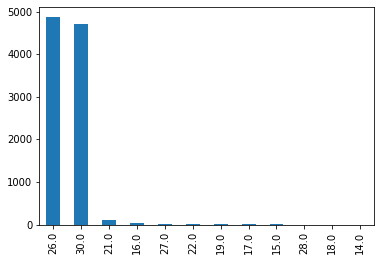

In [64]:
if AddressCleanserUtils.within_jupyter:
    osm_addresses.place_rank.value_counts().plot.bar()

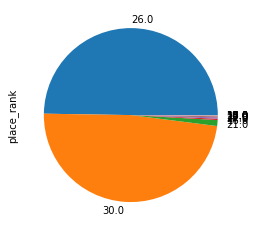

In [65]:
if AddressCleanserUtils.within_jupyter:
    osm_addresses.place_rank.value_counts().plot.pie()

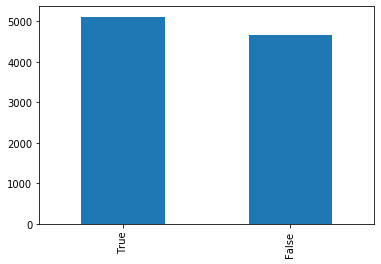

In [66]:
if AddressCleanserUtils.within_jupyter:
    osm_addresses.addr_out_number.isnull().value_counts().plot.bar()

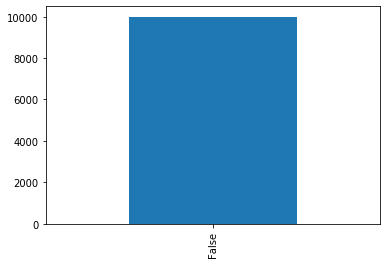

In [67]:
if AddressCleanserUtils.within_jupyter:
    addresses[config_module.housenbr_field].isnull().value_counts().plot.bar()

In [68]:
# Remark : only works when dask is not used 
# Gives times used of transformer, querying & processing osm, and checking results
if not with_dask:
    ts = AddressCleanserUtils.timestats
    tot = np.sum([ts[key] for key in ts])
    for key in ts: 
        log(f"{key:12}: {ts[key]} ({100*ts[key]/tot:.3} %)")

In [85]:
log("Country statistics")
x = addresses.merge(osm_addresses, how="outer") #[[config_module.country_field, "addr_out_country"]].value_counts()
log(pd.crosstab(x[config_module.country_field].fillna("[none]"), x["addr_out_country"].fillna("[none]"), margins=True))

[2020-05-04 08:20:56,381]  Country statistics


addr_out_country,België / Belgique / Belgien,France,Nederland,[none],All
CountryFR,,,,,
ALLEMAGNE,0,0,0,4,4
ALLEMAGNE ( RÉP. DÉM. ),0,0,0,1,1
ALLEMAGNE (RÉP.FÉD.),0,0,0,21,21
AUSTRALIE,0,0,0,1,1
AUTRICHE,0,0,0,2,2
BELGIQUE,9769,0,0,3,9772
BULGARIE,0,0,0,1,1
CHINE /RÉP. POP./,0,0,0,1,1
CORÉE DU SUD ( RÉP. DE ),0,0,0,1,1


# Output

In [ ]:
output_folder = address_file.rsplit(".", 1)[0]

import os

try:
    os.mkdir(output_folder)
except OSError:
    log ("Creation of the directory %s failed" % output_folder)
else:
    log ("Successfully created the directory %s " % output_folder)
    
    
output_filename_xls = output_folder + "/match.xlsx"
output_filename_pkl = output_folder + "/match.pkl"

nomatch_filename = output_folder + "/nomatch.xlsx"

reject_filename = output_folder + "/reject.xlsx"

stats_filename = output_folder + "/stats.xlsx"

In [ ]:
final_output = addresses.merge(osm_addresses, how="left")


log(f"Writing results on {output_filename_xls} ...")
try: 
    final_output.to_excel(output_filename_xls)
except Exception as e: 
    log("Failed ! ")
    log(e)
    
log(f"Writing results on {output_filename_pkl} ...")
try: 
    final_output.to_pickle(output_filename_pkl)
except Exception as e: 
    log("Failed ! ")
    log(e)
    

In [ ]:
log(f"Writing rejected on {reject_filename} ...")
try: 

    rejected_addresses_final.sort_values([config_module.addr_key_field]).set_index([config_module.addr_key_field,
                                                                               config_module.street_field,
                                                                               config_module.housenbr_field,
                                                                               config_module.postcode_field,
                                                                               config_module.city_field,
                                                                               config_module.country_field,
                                                                               "method"]).to_excel(reject_filename)
except Exception as e: 
    log("Failed ! ")
    log(e)
    

log(f"Writing nomatch on {nomatch_filename} ...")
try: 
    nomatch =  addresses[~addresses[config_module.addr_key_field].isin(osm_addresses[config_module.addr_key_field]) & ~addresses[config_module.addr_key_field].isin(rejected_addresses[config_module.addr_key_field])]
    nomatch.to_excel(nomatch_filename)
except Exception as e: 
    log("Failed ! ")
    log(e)
    

In [ ]:
log(f"Writing stats on {stats_filename} ...")
try: 
    with pd.ExcelWriter(stats_filename) as writer:
        _stats.to_excel(writer, "match_rate")
        
        pr_vc = osm_addresses.place_rank.value_counts()
        pr_vc = pd.concat([pr_vc, pr_vc/ osm_addresses.shape[0]], axis=1)
        pr_vc.columns = ["Count", "%"]
        pr_vc.to_excel(writer, "place_rank")

except Exception as e: 
    log("Failed ! ")
    log(e)
    

In [ ]:
log("Done !")
log(f"Total time : {datetime.now() - starting_time}")